In [1]:
import requests
import pandas as pd
import networkx as nx
import numpy as np

import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data

import time
import random

import matplotlib
import matplotlib.pyplot as plt

In [2]:
ARTIST = "The Killers"

### API keys and main parameters

SetList.fm

In [3]:
API_KEY = "ad30e075-cc83-41c3-8708-dfb5625a2330"

BASE_URL = "https://api.setlist.fm/rest/1.0"
MIN_SETLIST_LEN = 5
NUM_OF_PAGES = 6

Spotify

In [4]:
client_id = '1f9afb3cf4f444d3b3a2f9d3bf20a4dc'
client_secret = '12f145a677b54fe6b6b05c52dcbd433b'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

## SPOTIFY FUNCTIONS

In [121]:
def get_artist_picture(NAME):
    result = sp.search(NAME) #search query
    #Extract Artist's uri
    artist_uri = [x['uri'] for x in result['tracks']['items'][0]['artists'] if x['name'].lower() == NAME.lower()][0]
    return sp.artist(artist_uri)['images'][0]['url']


In [122]:
get_artist_picture('The killers')

'https://i.scdn.co/image/a841f0ee4f2d88c42f55f76c2cc6b588841f5d2f'

In [5]:
def get_albums_info(sp_albums):
    album_names = []
    album_uris = []
    for i in range(len(sp_albums['items'])):
        album_names.append(sp_albums['items'][i]['name'])
        album_uris.append(sp_albums['items'][i]['uri'])
    return album_names, album_uris

In [6]:
def albumSongs(uri, name, spotify_albums):
    album = uri #assign album uri to a_name
    spotify_albums[album] = {} #Creates dictionary for that specific album
    #Create keys-values of empty lists inside nested dictionary for album
    spotify_albums[album]['album'] = [] #create empty list
    spotify_albums[album]['track_number'] = []
    spotify_albums[album]['id'] = []
    spotify_albums[album]['name'] = []
    spotify_albums[album]['uri'] = []
    tracks = sp.album_tracks(album) #pull data on album tracks
    for n in range(len(tracks['items'])): #for each song track
            spotify_albums[album]['album'].append(name) #append album name tracked via album_count
            spotify_albums[album]['track_number'].append(tracks['items'][n]['track_number'])
            spotify_albums[album]['id'].append(tracks['items'][n]['id'])
            spotify_albums[album]['name'].append(tracks['items'][n]['name'])
            spotify_albums[album]['uri'].append(tracks['items'][n]['uri'])
    return spotify_albums

In [7]:
def get_artist_info(NAME):
    result = sp.search(NAME) #search query
    #Extract Artist's uri
    artist_uri = [x['uri'] for x in result['tracks']['items'][0]['artists'] if x['name'].lower() == NAME.lower()][0]

    #Pull all of the artist's albums
    sp_albums = sp.artist_albums(artist_uri, album_type='album')
    album_names, album_uris = get_albums_info(sp_albums)

    spotify_albums = {}
    album_count = 0
    checked_albs = []
    for i, name in zip(album_uris, album_names): #each album
        if name not in checked_albs:
            checked_albs.append(name)
            spotify_albums = albumSongs(i, name, spotify_albums)
            album_count+=1 #Updates album count once all tracks have been addedb
  
    return spotify_albums

In [182]:
def audio_features(album):
    #Add new key-values to store audio features
    album['popularity'] = []
    #create a track counter
    track_count = 0
    for track in album['uri']:
        #pull audio features per track
        features = sp.audio_features(track)
        pop = sp.track(track)
        album['popularity'].append(pop['popularity'])
        track_count+=1

In [183]:
def info_pd(spotify_albums):
    sleep_min = 2
    sleep_max = 5
    start_time = time.time()
    request_count = 0


    for i in spotify_albums:
        audio_features(spotify_albums[i])
        request_count+=1
        if request_count % 5 == 0:
            print(str(request_count) + " playlists completed")
            time.sleep(np.random.uniform(sleep_min, sleep_max))
    dic_df = {}
    dic_df['album'] = []
    dic_df['track_number'] = []
    dic_df['id'] = []
    dic_df['name'] = []
    dic_df['uri'] = []
    dic_df['popularity'] = []
    for album in spotify_albums: 
        for feature in dic_df.keys():
            dic_df[feature].extend(spotify_albums[album][feature])

    artist_df = pd.DataFrame.from_dict(dic_df)
    artist_df['name'] = artist_df['name'].apply(lambda x: x.lower())
    return artist_df

## CONCERT INFO FUNCTIONS

In [98]:
def get_setlist_songs(ARTIST, BASE_URL, API_KEY):
    artist_url = "{}/search/artists/?sort=relevance&artistName={}".format(BASE_URL, ARTIST)
    headers = {'x-api-key': API_KEY, 'Accept': 'application/json'}
    r = requests.get(artist_url, headers=headers)
    artists = r.json().get('artist')
    artist = artists[0]
    responses = []
    for i in range(1, NUM_OF_PAGES): 
        playlist_url = "{}/artist/{}/setlists/?p={}".format(BASE_URL, artist.get('mbid'), i)
        r = requests.get(playlist_url, headers=headers)
        responses.append(r.json())

        
    responses_setlist = map(lambda x: x.get('setlist'), responses)
    flattened_setlists = [item for sublist in responses_setlist for item in sublist if 'tour' in item.keys()]
    print(flattened_setlists)
    cleaned_setlists = list(map(lambda x: {
        'eventDate': x.get('eventDate'), 
        'songs': list(map(lambda z: z.get('name'), \
        [item for sublist in map(lambda y: y.get('song'), x.get('sets').get('set')) for item in sublist])) \
        , 
        'tour': x.get('tour').get('name'),
        'country': x.get('venue').get('city').get('country').get('code')
        }, flattened_setlists))
    
    cleaned_setlists = [x for x in cleaned_setlists if 'songs' in x.keys()]
    cleaned_setlists = [x for x in cleaned_setlists if len(x['songs']) > 5]
    only_songs = list(map(lambda x: ["begin"] + x.get('songs') + ["end"], cleaned_setlists))
    
    return cleaned_setlists, only_songs

In [99]:
def song_list_to_df(ARTIST, BASE_URL, API_KEY):
    cleaned_list, songs = get_setlist_songs(ARTIST, BASE_URL, API_KEY)
    pairs = []
    for concert in cleaned_list:
        setlist = concert['songs']
        setlist = ['begin'] + setlist + ['end']
        for i in range(len(setlist) - 1):
            pairs.append((setlist[i], setlist[i+1], concert['tour'], concert['country'], concert['eventDate']))

    df_pairs = pd.DataFrame(pairs)

    df_pairs = df_pairs.rename(columns={0:'song_org', 1:'next_song', 2:'tour', 3:'country', 4:'date'})
    the_tour = df_pairs.sort_values(by=['date']).iloc[0]['tour']
    df_pairs2 = df_pairs[df_pairs.tour == the_tour]
    
    length_concert = df_pairs.groupby('date').count().median()['song_org']
    b = df_pairs2.groupby('date').count()
    dates = b[(b.song_org < length_concert + 2) & (b.song_org > length_concert - 2) ].index
    
    df_pairs2 = df_pairs2[df_pairs.date.isin(dates)].groupby(['song_org', 'next_song']).size().reset_index().rename(columns={0:'weight'})
    
    return df_pairs, df_pairs2

### GET CONCERT INFO

In [100]:
info_complete, df_pairs = song_list_to_df(ARTIST, BASE_URL, API_KEY)

[{'id': '7be9f6cc', 'versionId': '63161647', 'eventDate': '19-09-2018', 'lastUpdated': '2019-02-09T21:22:49.000+0000', 'artist': {'mbid': '95e1ead9-4d31-4808-a7ac-32c3614c116b', 'name': 'The Killers', 'sortName': 'Killers, The', 'disambiguation': 'US rock band', 'url': 'https://www.setlist.fm/setlists/the-killers-23d6e097.html'}, 'venue': {'id': '1bd245bc', 'name': 'AsiaWorld-Arena', 'city': {'id': '1818727', 'name': 'Islands District', 'state': 'Hong Kong (general)', 'stateCode': '00', 'coords': {'lat': 22.45, 'long': 114.067}, 'country': {'code': 'HK', 'name': 'Hong Kong'}}, 'url': 'https://www.setlist.fm/venue/asiaworld-arena-islands-district-hong-kong-1bd245bc.html'}, 'tour': {'name': 'Wonderful Wonderful'}, 'sets': {'set': [{'song': [{'name': 'The Man'}, {'name': 'Somebody Told Me'}, {'name': 'Spaceman'}, {'name': 'The Way It Was'}, {'name': 'Shot at the Night'}, {'name': 'Run for Cover'}, {'name': 'Jenny Was a Friend of Mine'}, {'name': 'Smile Like You Mean It'}, {'name': 'For Re

In [208]:
most_played = info_complete[['song_org', 'next_song']].groupby('next_song').count().sort_values(by='song_org').reset_index()

In [214]:
most_played.iloc[-4:]['next_song'].unique()

array(['Somebody Told Me', 'Read My Mind', 'Human', 'Mr. Brightside'],
      dtype=object)

In [221]:
def get_statistics(info_complete):
    stats = {}
    first_song = info_complete[info_complete.song_org == 'begin'].groupby('next_song').count().\
                sort_values(by=['song_org']).reset_index()
    most_played = info_complete[['song_org', 'next_song']].groupby('next_song').count().\
                sort_values(by='song_org').reset_index()
    
    last_song = info_complete[info_complete.next_song == 'end'].groupby('song_org').count().\
                sort_values(by=['next_song']).reset_index()
    stats['first_song'] = first_song.iloc[-1].next_song
    stats['top_three'] = list(most_played.iloc[-3:]['next_song'].unique()[::-1])
    stats['most_played'] = most_played.iloc[-1]['next_song']
    stats['last_song'] = last_song.iloc[-1].song_org
    
    return stats
    
    

In [222]:
statistics = get_statistics(info_complete)

In [223]:
statistics

{'first_song': 'The Man',
 'top_three': ['Mr. Brightside', 'Human', 'Read My Mind'],
 'most_played': 'Mr. Brightside',
 'last_song': 'Mr. Brightside'}

### GET SPOTIFY INFO

In [184]:
spotify_albums = get_artist_info(ARTIST)
pd_artist = info_pd(spotify_albums)

retrying ...6secs
5 playlists completed
retrying ...2secs
10 playlists completed


In [185]:
pd_artist

,album,track_number,id,name,uri,popularity
0,Wonderful Wonderful (Deluxe),1,34Z7ksxNZ5UttoqD0ZLa6P,wonderful wonderful,spotify:track:34Z7ksxNZ5UttoqD0ZLa6P,43
1,Wonderful Wonderful (Deluxe),2,6U5ySz3l4LtpaJ37pr3bGU,the man,spotify:track:6U5ySz3l4LtpaJ37pr3bGU,49
2,Wonderful Wonderful (Deluxe),3,5IGvpvIDKS03xlvhPCJ9qS,rut,spotify:track:5IGvpvIDKS03xlvhPCJ9qS,43
3,Wonderful Wonderful (Deluxe),4,4TqowMxiy3kmV6jlxdldDm,life to come,spotify:track:4TqowMxiy3kmV6jlxdldDm,42
4,Wonderful Wonderful (Deluxe),5,6oy7lD7B9HScHz11HQ2P0F,run for cover,spotify:track:6oy7lD7B9HScHz11HQ2P0F,47
...,...,...,...,...,...,...
145,Hot Fuss,10,5TOSXYdmL0g0cjgS5EmERP,midnight show,spotify:track:5TOSXYdmL0g0cjgS5EmERP,41
146,Hot Fuss,11,67Xa6exVJYahtnETL0OCBa,everything will be alright,spotify:track:67Xa6exVJYahtnETL0OCBa,40
147,Hot Fuss,12,1RGJcbR0wOwtB12P0zuWLL,somebody told me - mylo mix,spotify:track:1RGJcbR0wOwtB12P0zuWLL,36
148,Hot Fuss,13,3RFumdbhGVlcOhVSTB0KVF,smile like you mean it - fischerspooner mix,spotify:track:3RFumdbhGVlcOhVSTB0KVF,32


In [14]:
length_concert = info_complete.groupby('date').count().median()['song_org']

In [15]:
info_complete.groupby('date').count().groupby('song_org').count()

,next_song,tour,country
song_org,,,
12,3,3,3
14,2,2,2
15,4,4,4
16,7,7,7
17,3,3,3
18,7,7,7
19,8,8,8
20,7,7,7
21,6,6,6


In [16]:
df_pairs[df_pairs.song_org == 'begin'].sort_values(by=['weight'])

,song_org,next_song,weight
91,begin,Run for Cover,1
90,begin,Mr. Brightside,6
92,begin,The Man,14


## CREATE GRAPH AND GET PLAYLIST

In [80]:
G = nx.from_pandas_edgelist(df_pairs, 'song_org', 'next_song', ['weight'], create_using=nx.DiGraph())

In [179]:
def get_playlist(G, pd_artist, source='begin', target='end'):
    visited = []
    cur = source

    while cur != target:
        if len(pd_artist[pd_artist['name'] == cur.lower()]) == 0:
            visited.append((cur, 0))
        else:
            popularity = pd_artist[pd_artist['name'] == cur.lower()].groupby('name').mean()
            visited.append((cur, popularity.iloc[0]['popularity']))

        weights = []
        neighs = []
        for n in G.neighbors(cur):
            if n not in visited:
                weights.append(np.exp(G.get_edge_data(cur, n).get('weight')))
                neighs.append(n)
        weights = np.asarray(weights)/sum(weights)
        if len(weights) == 0:
            cur = target
        else:
            cur = np.random.choice(neighs, 1,
                      p=weights)[0]
        
    return visited

In [180]:
playlist_go = get_playlist(G, pd_artist)

In [181]:
playlist_go

[('begin', 0),
 ('The Man', 57.5),
 ('Somebody Told Me', 64),
 ('Spaceman', 52),
 ('The Way It Was', 34.333333333333336),
 ('Shot at the Night', 0),
 ('Run for Cover', 55.5),
 ('Jenny Was a Friend of Mine', 49),
 ('Smile Like You Mean It', 53),
 ('For Reasons Unknown', 59),
 ('Human', 65.5),
 ('Mr. Brightside', 71)]

In [176]:
pd_artist['name'].unique()

array(['wonderful wonderful', 'the man', 'rut', 'life to come',
       'run for cover', 'tyson vs douglas', 'some kind of love',
       'out of my mind', 'the calling',
       'have all the songs been written?', 'money on straight',
       'the man - jacques lu cont remix', 'the man - duke dumont remix',
       'flesh and bone', 'runaways', 'the way it was', 'here with me',
       'a matter of time', 'deadlines and commitments',
       'miss atomic bomb', 'the rising tide', 'heart of a girl',
       'from here on out', 'be still', 'battle born', 'carry me home',
       'flesh and bone - jacques lu cont remix', 'prize fighter',
       'be still - alternate version', 'runaways - michel remix',
       'human - live from the royal albert hall / 2009',
       'this is your life - live from the royal albert hall / 2009',
       'somebody told me - live from the royal albert hall / 2009',
       'the world we live in - live from the royal albert hall / 2009',
       "i can't stay - live from 

In [167]:
pd_artist['name'] = pd_artist['name'].apply(lambda x: x.lower())

## VISUALIZE RESULTS

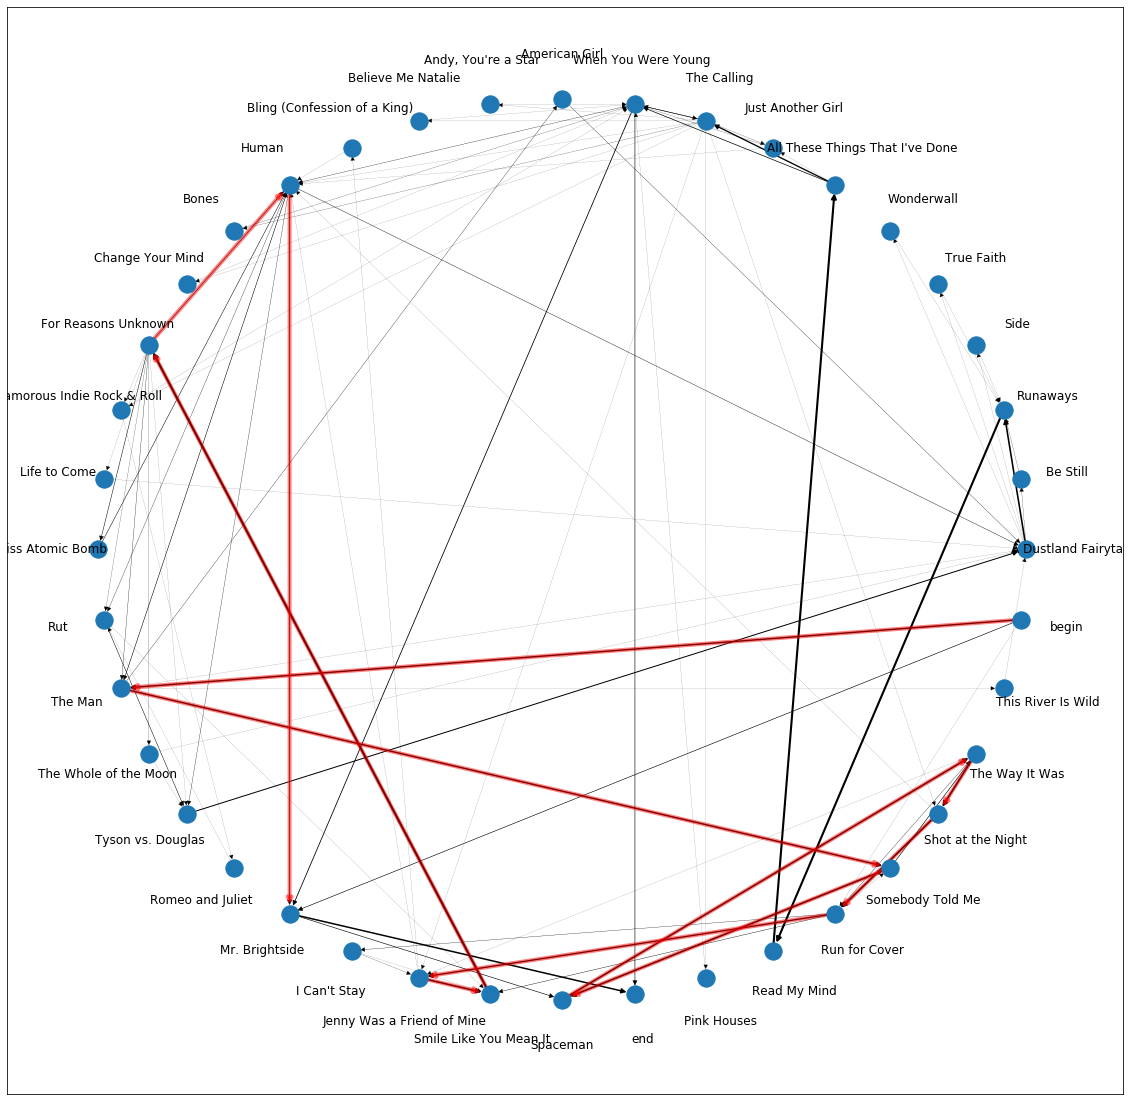

In [91]:
all_weights = []

f, ax = plt.subplots(figsize=(20,20))
pos=nx.circular_layout(G)
pos_higher = {}
for k, v in pos.items():
    pos_higher[k] = (v[0]*1.1, v[1]*1.1)
    
nx.draw_networkx_nodes(G.nodes, pos=pos)
nx.draw_networkx_labels(G, pos=pos_higher)
colors = ['r', 'b', 'y']
edges_1 = []
edges_2 = []
for i in range(len(playlist_go) - 1):
    edges_1.append((playlist_go[i], playlist_go[i+1]))

for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight'])

unique_weights = list(set(all_weights))

for weight in unique_weights:
    #4 d. Form a filtered list with just the weight you want to draw
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight*0.1
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='k', ax=ax)
    

for ctr, edges_l in enumerate([edges_1]):
    nx.draw_networkx_edges(G,pos=pos, edgelist=edges_l, edge_color = colors[ctr], style='dashed', ax=ax, width=4, alpha=0.5)


#plt.savefig('graph_song_{}'.format(ARTIST),bbox_inches = 'tight',
#    pad_inches = 0)

In [128]:
pd_artist[pd_artist.name.isin(playlist_go[1:])][['name', 'popularity']].groupby('name').mean()

,popularity
name,
For Reasons Unknown,59.000000
Human,65.500000
Mr. Brightside,71.000000
Smile Like You Mean It,53.000000
Somebody Told Me,64.000000
Spaceman,52.000000
The Man,57.500000
The Way It Was,34.333333
